In [22]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [23]:
import numpy as np 
import scipy.fft
from operators.legendre.setup_legendre import SimulationSetupLegendre
from operators.poisson_solver import gmres_solver
from operators.legendre.legendre_operators import xi_legendre, charge_density_legendre, total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

# Legendre weak Landau damping 

In [25]:
setup = SimulationSetupLegendre(Nx=51,
                                Nv_e=50,
                                epsilon=1e-2,
                                v_a=-10,
                                v_b=10,
                                gamma=0,
                                L=2 * np.pi,
                                dt=1e-2,
                                T0=0,
                                T=10,
                                nu=0)

In [26]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) /(setup.v_b - setup.v_a)

In [27]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(10**4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

# simulation results

In [28]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../../data/legendre/weak_landau/sol_u_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../../data/legendre/weak_landau/sol_t_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(2550, 1001)
(1001,)


In [29]:
runtime = np.load("../../data/legendre/weak_landau/sol_runtime_Nv_" + str(setup.Nv_e) + "_Nx_" + str(setup.Nx)
            + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([13.212473  , 13.35442805])

In [30]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [37]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv_e,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv_e,  setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_midpoint_u, (setup.Nv_e, setup.Nx, len(sol_midpoint_t)))
# periodicity enforced
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    # periodicity enforced
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density_legendre(q_e=setup.q_e, q_i=setup.q_i,
                         C0_e=state_e_midpoint[0, :setup.Nx, ii], 
                         C0_i=np.ones(setup.Nx)/(setup.v_b - setup.v_a),
                         v_a=setup.v_a, v_b=setup.v_b)
    print(np.sum(rho))
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, a_tol=1e-12, r_tol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

2.914335439641036e-15
2.6367796834847468e-15
2.4980018054066022e-15
2.7755575615628914e-15
3.608224830031759e-15
3.608224830031759e-15
3.3306690738754696e-15
3.3306690738754696e-15
3.3306690738754696e-15
3.191891195797325e-15
3.3306690738754696e-15
3.747002708109903e-15
3.191891195797325e-15
3.469446951953614e-15
3.469446951953614e-15
3.3306690738754696e-15
3.608224830031759e-15
3.747002708109903e-15
3.747002708109903e-15
4.3021142204224816e-15
4.440892098500626e-15
4.718447854656915e-15
4.9960036108132044e-15
4.85722573273506e-15
4.9960036108132044e-15
4.579669976578771e-15
4.9960036108132044e-15
4.3021142204224816e-15
4.0245584642661925e-15
4.579669976578771e-15
4.440892098500626e-15
4.718447854656915e-15
4.3021142204224816e-15
4.9960036108132044e-15
4.718447854656915e-15
4.85722573273506e-15
4.440892098500626e-15
4.718447854656915e-15
4.579669976578771e-15
5.134781488891349e-15
5.134781488891349e-15
5.134781488891349e-15
4.85722573273506e-15
4.579669976578771e-15
4.0245584642661925e

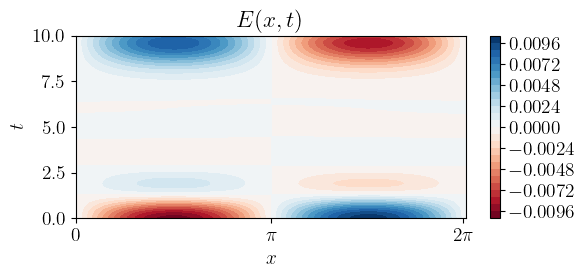

In [32]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

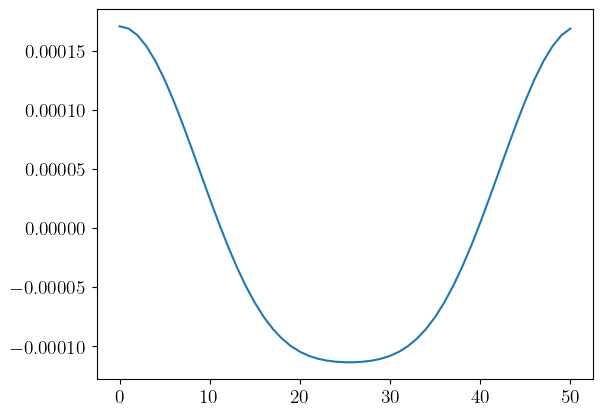

In [36]:
_ = plt.plot(charge_density_legendre(q_e=setup.q_e, q_i=setup.q_i,
                         C0_e=state_e_midpoint[0, :setup.Nx, 500], 
                         C0_i=np.ones(setup.Nx)/(setup.v_b - setup.v_a),
                         v_a=setup.v_a, v_b=setup.v_b))

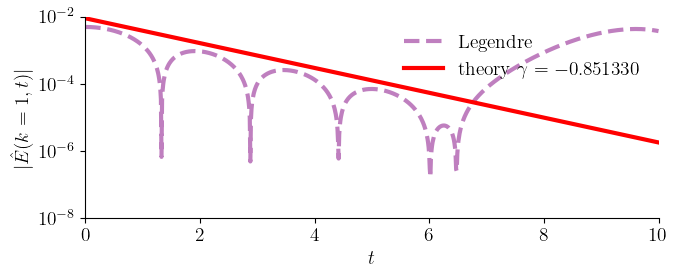

In [34]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.abs(np.fft.fft(E_midpoint, axis=0, norm="forward")[1, :]), "--", c="purple", alpha=0.5, linewidth=3, label="Legendre") 
ax.plot(sol_midpoint_t, 0.009*np.exp(-0.851330*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.851330$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(k=1, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_ylim(1e-8, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=14, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../../figures/legendre/weak_landau/weak_landau_damping_legendre.png", dpi=300)

# conservation laws: mass, momentum, and energy

### mass conservation

In [14]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass_legendre(state=state_e_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)\
                        +total_mass_legendre(state=state_i_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx)

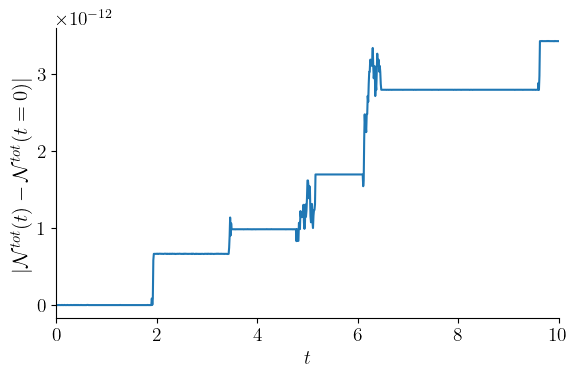

In [15]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [16]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum_legendre(state=state_e_midpoint[:, :-1, ii],
                                                    v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)\
                            +total_momentum_legendre(state=state_i_midpoint[:, :-1, ii], 
                                                     v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_i)

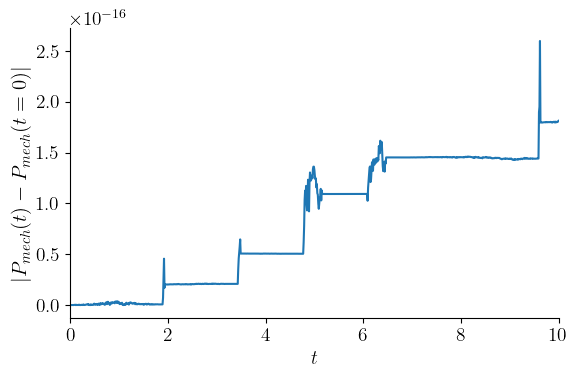

In [17]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [18]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k_legendre(state=state_e_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_e)\
                           +total_energy_k_legendre(state=state_i_midpoint[:, :-1, ii], v_a=setup.v_a, v_b=setup.v_b, dx=setup.dx, m_s=setup.m_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

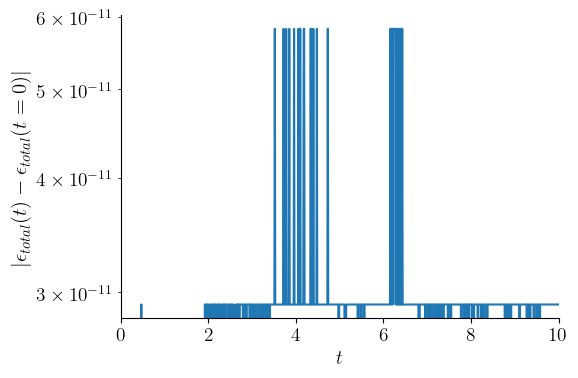

In [19]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

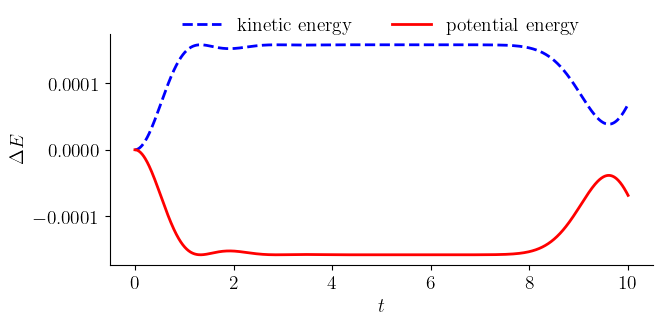

In [20]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$t$")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

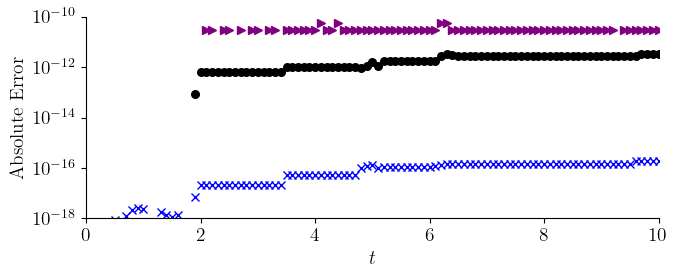

In [21]:
# plot the analytic and numerical conservation properties
skip = 10

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_ylim(1e-18, 1e-10) 
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
# legend = ax.legend(ncols=2, fontsize=14, loc='upper center')
# text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
# legend.get_frame().set_alpha(0)
plt.tight_layout()